In [17]:
%reset -sf

import pandas as pd
import numpy as np
import get_data as gd
import atlas_plot as ap
import gc

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [18]:
np.random.seed(42)  # set random seed
sampling = int(1e5)
processor = gd.DataProcessor(sampling=sampling)
path = "/root/work/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']



In [19]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [20]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["pz"][cut_pre])
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (46669, 10)
      MET_px     MET_py          E         px         py         pz  \
6  37.888869  22.746950  74.499953 -70.358812  63.190359  18.347104   
7 -25.957257 -13.907031  94.090484  30.966543  -5.458809  35.441430   
9  -3.723773 -12.730751  96.640594 -22.241205  15.650315  55.572746   

            E        px         py         pz  
6   29.805779  8.641208  -7.174451  69.782766  
7   39.837117  8.476649  30.656191  39.285973  
9  104.243320  1.825960 -12.914804  22.560578  

dinu_kin shape: (46669, 1)
          pz
6  88.129869
7  74.727402
9  78.133324



13248

In [21]:
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

from sklearn.model_selection import train_test_split

indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, sampling)
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(), train_size=0.8, test_size=0.2, random_state=42
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = dinu_kin[train_indices]
valid_x = dinu_kin[valid_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
valid_y = MET_kin[valid_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (80000, 1);
Validing data shape: (10000, 1);
Testing data shape: (10000, 1).
Y (Observed)
Training data shape: (80000, 10);
Validing data shape: (10000, 10);
Testing data shape: (10000, 10).



In [22]:
def build_model():
    model = keras.models.Sequential()

    # encoder
    model.add(layers.Flatten(input_shape=(train_y.shape[-1],)))
    model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # bottleneck
    model.add(layers.Dense(units=2, activation="relu"))
    # decoder
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Last dense layers
    model.add(layers.Dense(units=1, activation="linear"))

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    model.summary()

    return model

In [23]:
model = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 88        
                                                                 
 batch_normalization_2 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
 dense_6 (Dense)             (None, 4)                 12        
                                                      

In [24]:
# Load the TensorBoard notebook extension.
import datetime

# set log file
%rm -r ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=False,)

stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_y,
    y=train_x,
    validation_data=(valid_y, valid_x),
    epochs=64,
    batch_size=256,
    verbose=2,
    callbacks=[stop_early, tensorboard_callback],
)

Epoch 1/64
313/313 - 3s - loss: 0.5493 - val_loss: 0.2633 - 3s/epoch - 11ms/step
Epoch 2/64
313/313 - 2s - loss: 0.1018 - val_loss: 0.0384 - 2s/epoch - 5ms/step
Epoch 3/64
313/313 - 2s - loss: 0.0527 - val_loss: 0.0145 - 2s/epoch - 5ms/step
Epoch 4/64
313/313 - 2s - loss: 0.0399 - val_loss: 0.0091 - 2s/epoch - 5ms/step
Epoch 5/64
313/313 - 2s - loss: 0.0350 - val_loss: 0.0042 - 2s/epoch - 5ms/step
Epoch 6/64
313/313 - 2s - loss: 0.0307 - val_loss: 0.0026 - 2s/epoch - 5ms/step
Epoch 7/64
313/313 - 2s - loss: 0.0331 - val_loss: 0.0019 - 2s/epoch - 5ms/step
Epoch 8/64
313/313 - 2s - loss: 0.0321 - val_loss: 0.0015 - 2s/epoch - 5ms/step
Epoch 9/64
313/313 - 2s - loss: 0.0303 - val_loss: 0.0012 - 2s/epoch - 5ms/step
Epoch 10/64
313/313 - 2s - loss: 0.0283 - val_loss: 0.0023 - 2s/epoch - 5ms/step
Epoch 11/64
313/313 - 2s - loss: 0.0279 - val_loss: 0.0013 - 2s/epoch - 5ms/step
Epoch 12/64
313/313 - 2s - loss: 0.0281 - val_loss: 0.0012 - 2s/epoch - 5ms/step
Epoch 13/64
313/313 - 2s - loss: 0.0

In [25]:
x_pred = model.predict(test_y)
pred = x_pred.flatten()
truth = test_x.flatten()

313/313 [==============================] - 0s 1ms/step


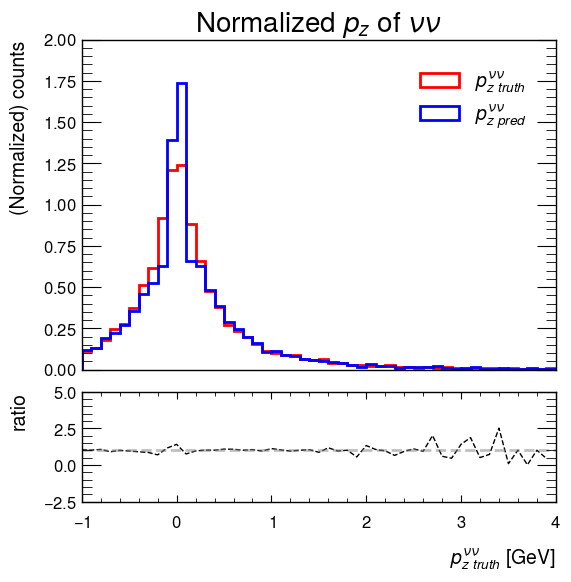

<Figure size 800x600 with 0 Axes>

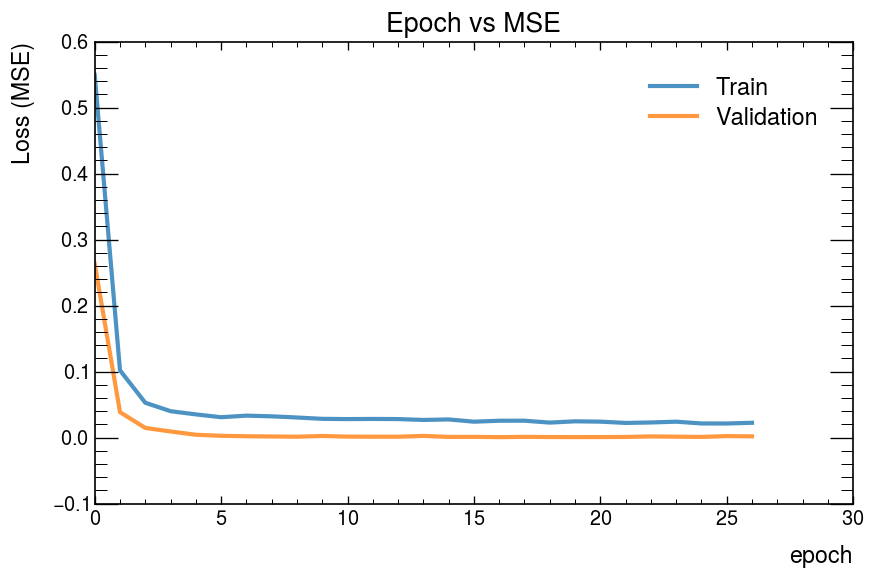

<Figure size 800x600 with 0 Axes>

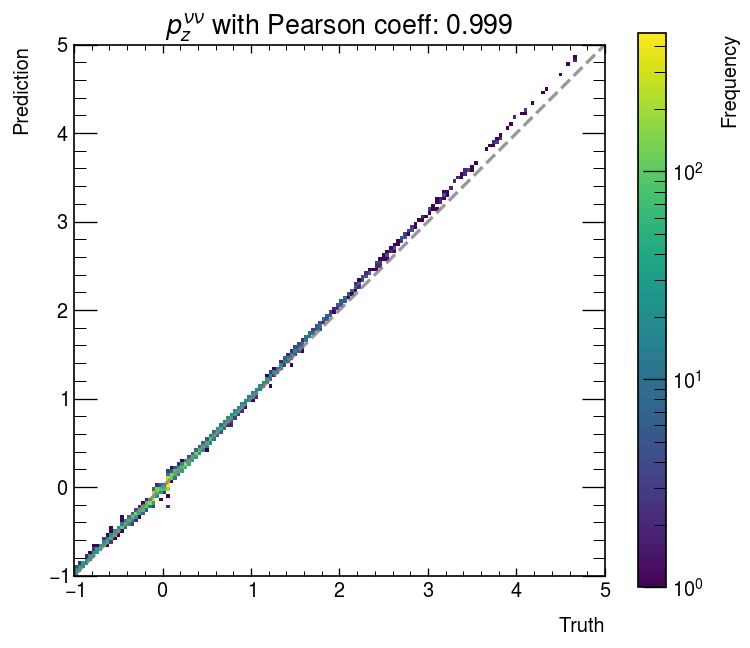

<Figure size 800x600 with 0 Axes>

In [26]:
plot = ap.Plotter()

plot.plot_hist(
    [truth, pred],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Normalized $p_{z}$ of $\nu\nu$",
    [-1, 4],
)
plot.plot_loss_history(history)

import scipy as sp

plot.plot_2d_histogram(
    pred,
    truth,
    r"$p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(truth, pred)[0]:.3f}",
    range=[-1, 5],
)

In [27]:
# Background

processor = gd.DataProcessor(sampling=sampling)
path = "/root/work/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

['/root/work/truth/background/CGLMP.npz', '/root/work/truth/background/Higgs.npz', '/root/work/truth/background/LeadLepton.npz', '/root/work/truth/background/LeptonM.npz', '/root/work/truth/background/LeptonP.npz', '/root/work/truth/background/LmNu.npz', '/root/work/truth/background/LpNu.npz', '/root/work/truth/background/MET.npz', '/root/work/truth/background/WmBoson.npz', '/root/work/truth/background/WpBoson.npz', '/root/work/truth/background/diLepton.npz', '/root/work/truth/background/subLeadLepton.npz', '/root/work/truth/background/xi_xyz.npz']



In [28]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [29]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["pz"][cut_pre])
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (67476, 10)
      MET_px     MET_py          E         px         py          pz  \
0 -16.289995   1.923795  42.881410 -48.357500 -10.579890  215.482750   
2  42.541232 -18.377646  90.541180 -10.641389 -23.928760  -10.243729   
4  22.820836  47.004016  41.051137  31.271631 -87.007633 -261.401500   

            E          px         py          pz  
0   26.282906  101.685922  13.681502  109.136266  
2  196.067578  -34.208898  41.079426   43.639004  
4   59.980094  -19.785096  22.434146  -33.566086  

dinu_kin shape: (67476, 1)
           pz
0  324.619016
2   33.395274
4 -294.967586



31721

In [30]:
SCALAR_int_bkg = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET_bkg = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

x, y = dinu_kin[test_indices], MET_kin[test_indices]

print(f"X (Interest) data shape: {x.shape};\nY (Observed) data shape: {y.shape}.")
print()

X (Interest) data shape: (10000, 1);
Y (Observed) data shape: (10000, 10).



In [31]:
x_pred = model.predict(y)
pred = x_pred.flatten()
truth = x.flatten()

313/313 [==============================] - 0s 1ms/step


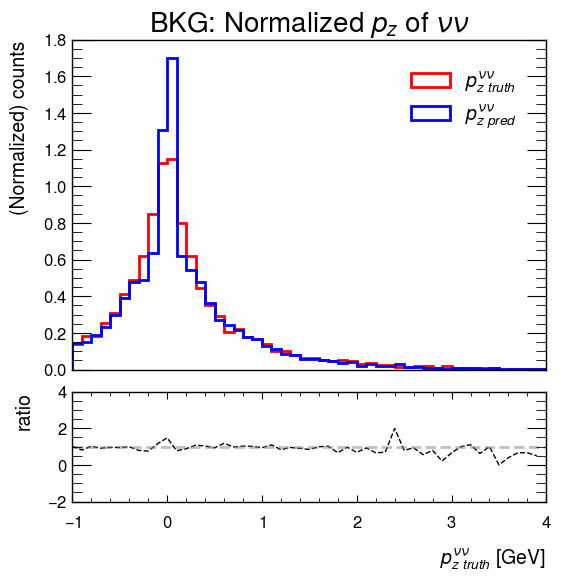

<Figure size 800x600 with 0 Axes>

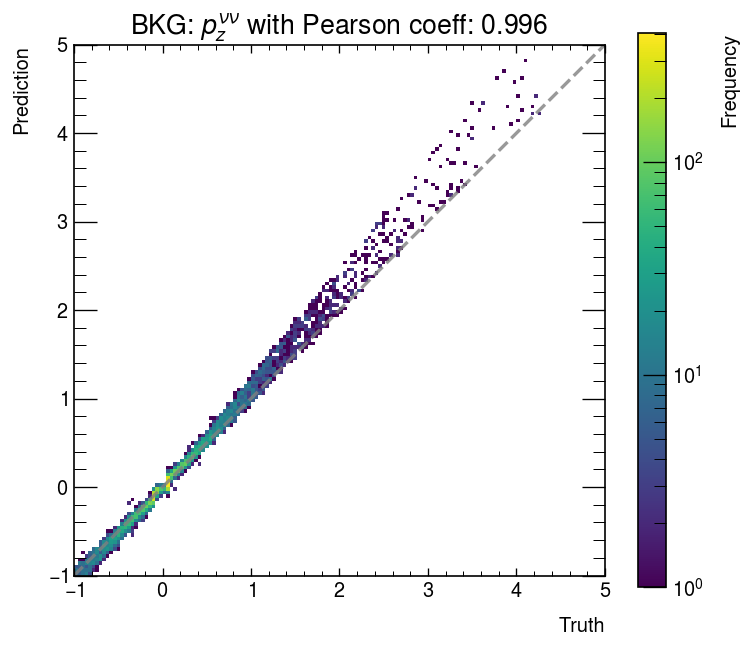

<Figure size 800x600 with 0 Axes>

In [32]:
plot = ap.Plotter()

plot.plot_hist(
    [truth, pred],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    "BKG: " + r"Normalized $p_{z}$ of $\nu\nu$",
    [-1, 4],
)

plot.plot_2d_histogram(
    pred,
    truth,
    "BKG: "
    + r"$p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(truth, pred)[0]:.3f}",
    range=[-1, 5],
)